# Yeast bioinformatic analysis 
Written by [Peter McHale](http://ccbs-76.bio.uci.edu/~petermchale/). 

This Notebook lives at [Github](https://github.com/petermchale/yeast_bioinformatics). Follow [these instructions](http://jupyter.readthedocs.io/en/latest/install.html) to execute the Notebook using Python 3.x.  Otherwise, [view this Notebook](http://nbviewer.jupyter.org/github/petermchale/yeast_bioinformatics/blob/master/analysis.ipynb) in read-only mode using [Jupyter Notebook Viewer](http://nbviewer.jupyter.org/).

## Research Question

The eukaryotic genome is adorned by molecules called transcription factors (TFs). At any given time, some of these are regulating gene expression, e.g. by interacting with RNA polymerase, but others are not. **How can we distinguish the functional TF-DNA binding events from a potentially large background of non-functional binding events?**

## Quantifying TF-DNA binding

To approach this question, we first need to quantify the strength with which TFs bind DNA. A TF binds DNA by making contact with a sequence of $L$ nucleotides 

\begin{equation} 
\vec{s} = \langle s_1, s_2, \ldots, s_L\rangle,
\end{equation} 

where $s_i \in \{A,C,G,T\}$. Denote by $E(\vec{s})$ the binding energy of a given TF to a DNA sub-sequence $\vec{s}$. 
With binding lengths of $L = 10-20$ nucleotides, there are too many possible $\vec{s}$ to measure $E(\vec{s})$ exhaustively.
Fortunately, the contribution of each nucleotide to the binding energy of the sub-sequence is approximately independent and additive: 

\begin{equation} 
E(\vec{s}) = \sum_{i=1}^L \epsilon_i(s_i),
\end{equation}

reducing the impractical problem of determining the large number of values of $E(\vec{s})$ to the practical problem of the determining the 
 $L\times 4$ energy matrix, $\epsilon_i(s)$. This matrix has been determined for a TF called Gal4 using *in vitro* measurements of the equilibrium binding constants 
 
\begin{equation} 
K(\vec{s}) \propto e^{-\beta E(\vec{s})} 
\end{equation} 

for all sequences $\vec{s}$ that differ in just one nucleotide from a given sequence. I manually fetched these data from the literature [[Liang et al 1996](https://www.ncbi.nlm.nih.gov/pubmed/8668194)], and stored them in the file `data/Gal4_affinity.in`. 

In [1]:
import sys, os 
sys.path.append(os.getcwd() + '/source')

from extract import createEnergyMatrix
energy_matrix = createEnergyMatrix('data/Gal4_affinity.in')

Here, I have stored the energy matrix as a list of dictionaries for computational reasons, but we can use `pandas` to visualize it:

In [2]:
import pandas as pd 
df = pd.DataFrame(energy_matrix)
df

,A,C,G,T
0,2.426816,0.000000,3.132951,2.957252
1,3.800451,3.800451,0.000000,3.800451
2,3.800451,3.800451,0.000000,3.800451
3,0.000000,0.804719,0.601986,0.885978
4,0.143841,0.000000,0.693147,0.000000
5,0.693147,0.143841,0.693147,0.000000
6,0.000000,1.497866,1.103637,0.000000
7,0.554331,0.000000,1.609438,0.693147
8,0.000000,2.120264,2.120264,0.000000
9,0.693147,1.609438,0.000000,0.554331


In the above data structure:
* row labels are positions within a binding site
* column labels are the identities of nucleotides at those positions
* matrix elements are TF-DNA binding energies

So, for example, a DNA sequence that binds optimally to Gal4 can be extracted by listing the nucleotides with the lowest energy at each position:



In [3]:
print(df.idxmin(axis=1))

0     C
1     G
2     G
3     A
4     C
5     T
6     A
7     C
8     A
9     G
10    A
11    A
12    A
13    T
14    C
15    C
16    G
dtype: object


## Extracting the yeast DNA sequence

I manually downloaded, from the [Saccharomyces Genome Database](http://www.yeastgenome.org/), the DNA sequence of the third chromosome of yeast, stored in [FASTA format](https://en.wikipedia.org/wiki/FASTA_format), and read it into a  string:

In [4]:
from extract import getFasta
with open('data/chr03.fsa') as f:
    header, chromosome = getFasta(f)
print('\nHere is the beginning of the DNA sequence of the chromosome:\n')
print(chromosome[:100])
print('\nThere are ', len(chromosome), 'nucleotides in this chromosome')


Here is the beginning of the DNA sequence of the chromosome:

CCCACACACCACACCCACACCACACCCACACACCACACACACCACACCCACACACCCACACCACACCACACCCACACCACACCCACACACCCACACCCAC

There are  316617 nucleotides in this chromosome


## Distribution of TF-DNA binding energies genome-wide

With the energy matrix and chromosome sequence in hand, I next computed the energy with which Gal4 binds every possible sub-sequence of length $L = 17$ on the chromosome:

In [5]:
from auxFunctions import calcEnergyListWithMatrix
TFBS = calcEnergyListWithMatrix(chromosome, energy_matrix)
TFBS.head()

,TF-DNA binding energy,binding-site start position,binding-site end position
0,18.328334,0,17
1,20.838887,1,18
2,20.147337,2,19
3,26.295040,3,20
4,18.686354,4,21


Here is how those TF-DNA binding energies are distributed throughout the genome:

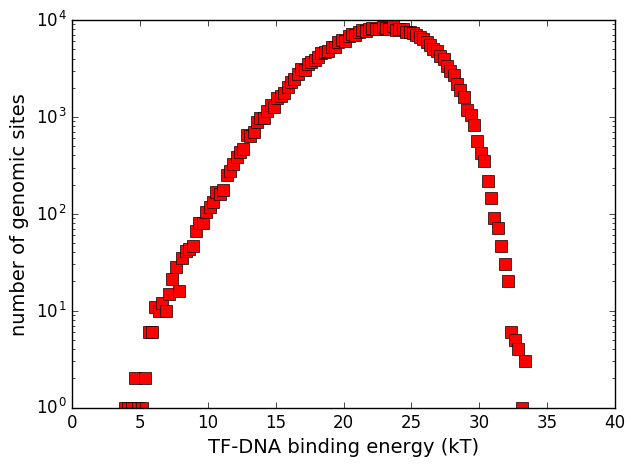

In [6]:
import numpy as np 
from matplotlib import pyplot as plt
from auxFunctions import binList
%matplotlib inline

energyBins, numberSites = binList(TFBS['TF-DNA binding energy'], xMin=-5.0, xMax=50, binWidth=0.25)

fontsize = 14
fontsize_tick = 12
fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(energyBins, numberSites, linewidth=0, marker='s', markersize=8, color='red')
ax.set_xlabel('TF-DNA binding energy (kT)', fontsize=fontsize)
ax.set_ylabel('number of genomic sites', fontsize=fontsize)
ax.set_yscale('log')
ax.set_xlim(0, 40)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

Putting the y-axis on a log scale reveals that the distribution is approximately parabolic, implying that on a linear scale the distribution is approximately Gaussian. This is expected from the fact that each TF-DNA binding energy is a sum of single-nucleotide energies that are, to a good approximate, independently and identically distributed (Central Limit Theorem). 

Notice also that, though highly-specific (low-energy) sites do indeed exist, the sheer number of less-specific (intermediate- to high-energy) sites across the genome can, in principle, soak up a significant number of TFs. 

## Extracting yeast promoters

To identify where regulatory regions of genes are likely to be, I downloaded the following [General Feature Format](https://en.wikipedia.org/wiki/General_feature_format) file from the [Saccharomyces Genome Database](http://www.yeastgenome.org/):

In [7]:
!head -20 data/saccharomyces_cerevisiae_chr03.gff

##gff-version   3
#date Tue May  8 19:35:07 2007
#
# Saccharomyces cerevisiae S288C genome
#
# Features from the 16 nuclear chromosomes labeled chrI to chrXVI,
# plus the mitochondrial genome labeled chrMito
#
# Created by Saccharomyces Genome Database (http://www.yeastgenome.org/)
#
# Weekly updates of this file are available via Anonymous FTP from:
# ftp://ftp.yeastgenome.org/yeast/data_download/chromosomal_feature/saccharomyces_cerevisiae.gff
#
# Please send comments and suggestions to yeast-curator@yeastgenome.org
#
# SGD is funded as a National Human Genome Research Institute Biomedical Informatics Resource from
# the U. S. National Institutes of Health to Stanford University.  The staff of SGD is listed at:
# http://www.yeastgenome.org/SGD-staff.html
#
chrIII	SGD	repeat_family	1	360	.	-	.	ID=TEL03L-TR;Name=TEL03L-TR;Note=Terminal%20stretch%20of%20telomeric%20repeats%20on%20the%20left%20arm%20of%20Chromosome%20III;dbxref=SGD:S000028872


This file contains all genomic features on the third chromosome of this species. I located the coding-sequence features, and used them to extract regions of DNA that lie upstream of each transcription start site. 

In [8]:
def extractPromoters():
    """ parse saccharomyces_cerevisiae_chr03.gff and extract promoters """

    promLength = 100

    with open('data/saccharomyces_cerevisiae_chr03.gff') as fin:

        # skip over header lines
        line = fin.readline()
        while line[0] == "#":
            line = fin.readline()

        features = []
        while line:
            seqid, source, feature_type, start, end, score, strand, phase, attributes = line.split()
            if feature_type == 'CDS':
                attributes = attributes.split(';')
                initDict = [attribute.split('=') for attribute in attributes]
                attributes = dict(initDict)
                systematicGeneName = attributes['Parent']

                if 'orf_classification' in attributes:
                    classification = attributes['orf_classification']
                else:
                    classification = '.'
                if 'gene' in attributes:
                    standardGeneName = attributes['gene']
                else:
                    standardGeneName = '.'

                # which DNA strand the gene is encoded on determines where the promoter is located
                if strand == '+':
                    promStart = int(start) - promLength
                    promEnd = int(start)
                elif strand == '-':
                    promStart = int(end)
                    promEnd = int(end) + promLength

                promoter = chromosome[max(promStart, 0):promEnd]
                features += [(standardGeneName, systematicGeneName, classification, promStart, promEnd, promoter)]
            line = fin.readline()

    return pd.DataFrame(data=features, columns=['standard gene name', 'systematic gene name', 
                                                'classification', 'promoter start position', 
                                                'promoter end position', 
                                                'promoter sequence'])

promoters = extractPromoters()
promoters.head()

,standard gene name,systematic gene name,classification,promoter start position,promoter end position,promoter sequence
0,.,YCL076W,Dubious,1292,1392,TAGTACTTAAGAAACTACAGTTTCTATGTACGAAAGCAGTAACTAT...
1,.,YCL075W,.,2026,2126,ATTCTGTAAATTAAATGCGTCATCGAATTCATCATCTTCGGTCTCA...
2,.,YCL074W,.,2724,2824,GGTATTGACTATCAGGAAACCTTTGCACCAGTCATTCGATATGACT...
3,.,YCL073C,Uncharacterized,8326,8426,CCGATAATTTATTTACTTGATTATTCCTTTTTTTTTTTTTTCTCTT...
4,VBA3,YCL069W,Verified,9606,9706,TGGGGAAGATTCGCATCTATCATAGGTTTCCAGCATAGTCTCATTT...


I have placed a `.` in a field to indicate **missing data**.

## Determining whether potential TF binding sites lie in promoters

I next classified each $L$-subsequence (potential binding site) according to whether it lies in a promoter region or not, and added that information as two new columns in the appropriate `pandas` data frame:

In [9]:
import warnings
warnings.filterwarnings('ignore')

TFBS_high_affinity = TFBS[TFBS['TF-DNA binding energy'] < 10]

TFBS_high_affinity_categorical_variable = [0]*len(TFBS_high_affinity)
TFBS_high_affinity_promoter = ['.']*len(TFBS_high_affinity)
count = -1
for TFBS_index, TFBS_row in TFBS_high_affinity.iterrows():
    count += 1
    TFBS_start = TFBS_row['binding-site start position']
    TFBS_end = TFBS_row['binding-site end position']
    for promoter_index, promoter_row in promoters.iterrows():
        promoter_start = promoter_row['promoter start position']
        promoter_end = promoter_row['promoter end position']
        if (promoter_start < TFBS_start) and (TFBS_end < promoter_end):
            TFBS_high_affinity_categorical_variable[count] = 1
            TFBS_high_affinity_promoter[count] = promoter_row['systematic gene name']
            break
TFBS_high_affinity['promoter categorical variable'] = TFBS_high_affinity_categorical_variable
TFBS_high_affinity['promoter'] = TFBS_high_affinity_promoter
TFBS_high_affinity.head()

,TF-DNA binding energy,binding-site start position,binding-site end position,promoter categorical variable,promoter
1549,9.595544,1549,1566,0,.
2288,8.433015,2288,2305,0,.
2737,9.996220,2737,2754,1,YCL074W
2873,7.729358,2873,2890,0,.
3418,8.005181,3418,3435,0,.


## Are promoters enriched for subsequences that bind TFs tightly? 

I used [scikit-learn](http://scikit-learn.org/stable/) to determine whether subsequences with greater affinity for the TF (i.e. lower energy) tend to be located in promoter regions more often than you'd expect by chance:

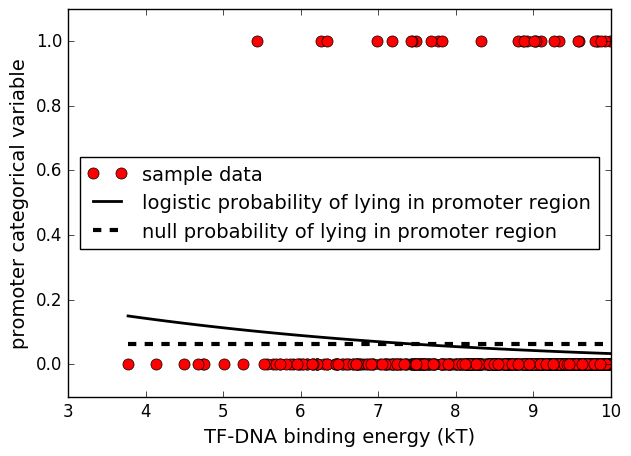

In [10]:
energies = TFBS_high_affinity['TF-DNA binding energy']
categories = TFBS_high_affinity['promoter categorical variable']

# sample data
fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(energies, categories, 
        linewidth=0, marker='o', markersize=8, color='red', label='sample data')
ax.set_xlabel('TF-DNA binding energy (kT)', fontsize=fontsize)
ax.set_ylabel('promoter categorical variable', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)
ax.set_ylim(-0.1, 1.1)

# logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
energies_rs = energies.values.reshape((len(energies),1))
lr.fit(energies_rs, categories)
x = np.linspace(energies.min(),energies.max())
x_rs = x.reshape((len(x), 1))
probs = lr.predict_proba(x_rs)
ax.plot(x, probs[:,1], linewidth=2, marker=None, color='black', 
        label='logistic probability of lying in promoter region')

# probability that a randomly choosen site lies in a promoter 
number_promoters, number_cols = promoters.shape
promoter_size = len(promoters['promoter sequence'][0])
promoter_size_summed_over_chromosome = number_promoters*promoter_size
chromosome_size = len(chromosome)
null_probability_of_random_bp_lying_in_promoter = float(promoter_size_summed_over_chromosome)/float(chromosome_size)
ax.plot([x.min(), x.max()], 
        [null_probability_of_random_bp_lying_in_promoter, 
         null_probability_of_random_bp_lying_in_promoter],
        'r--',
        linewidth=3, marker=None, color='black',
        label='null probability of lying in promoter region')

# label the plot
legend = ax.legend(loc='center', fontsize=fontsize)

## Actionable insight 

The data show that high-affinity subsequences are more likely to lie in promoter regions than expected by chance, suggesting that there has been evolutionary pressure to retain strong binding sites in promoters. **The actionable insight is therefore that searches for new *functional* TF binding sites should be focused on promoter regions.**